In [4]:
#Import Library
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

###Mounting Dataset from GDrive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_file_path = '/content/dogSkinDisease.zip'  # Adjusted path based on your Colab directory

# Extract the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dogSkinDisease')  # Extracting to a specific folder within /content

# Check the extracted contents
extracted_files = os.listdir('/content/dogSkinDisease')  # Adjusted to match the extracted folder path
print(f"Extracted files: {extracted_files}")


Extracted files: ['test', 'train', 'validation']


In [14]:
import os

# Define the base directory
base_dir = "/content/dogSkinDisease"  # Adjusted to match the extracted folder path in Colab

# Function to count images safely
def count_images(directory):
    return len(os.listdir(directory)) if os.path.exists(directory) else 0

# Training set
print(f"There are {count_images(base_dir + '/train/flea_allergy')} train set images of flea allergy.")
print(f"There are {count_images(base_dir + '/train/hotspot')} train set images of hotspot.")
print(f"There are {count_images(base_dir + '/train/mange')} train set images of mange.")
print(f"There are {count_images(base_dir + '/train/ringworm')} train set images of ringworm.")
print()

# Validation set
print(f"There are {count_images(base_dir + '/validation/flea_allergy')} val set images of flea allergy.")
print(f"There are {count_images(base_dir + '/validation/hotspot')} val set images of hotspot.")
print(f"There are {count_images(base_dir + '/validation/mange')} val set images of mange.")
print(f"There are {count_images(base_dir + '/validation/ringworm')} val set images of ringworm.")
print()

# Testing set
print(f"There are {count_images(base_dir + '/testing/flea_allergy')} test set images of flea allergy.")
print(f"There are {count_images(base_dir + '/testing/hotspot')} test set images of hotspot.")
print(f"There are {count_images(base_dir + '/testing/mange')} test set images of mange.")
print(f"There are {count_images(base_dir + '/testing/ringworm')} test set images of ringworm.")


There are 76 train set images of flea allergy.
There are 96 train set images of hotspot.
There are 63 train set images of mange.
There are 138 train set images of ringworm.

There are 20 val set images of flea allergy.
There are 20 val set images of hotspot.
There are 20 val set images of mange.
There are 20 val set images of ringworm.

There are 0 test set images of flea allergy.
There are 0 test set images of hotspot.
There are 0 test set images of mange.
There are 0 test set images of ringworm.


###Train Val Generator

In [15]:
TRAINING_DIR = "/content/dogSkinDisease/train"
VALIDATION_DIR = "/content/dogSkinDisease/validation"
TESTING_DIR = "/content/dogSkinDisease/testing"

TRAINING_FLEA_DIR = "/content/dogSkinDisease/train/flea_allergy"
VALIDATION_FLEA_DIR = "/content/dogSkinDisease/validation/flea_allergy"
TEST_FLEA_DIR = "/content/dogSkinDisease/testing/flea_allergy"

TRAINING_HOTSPOT_DIR = "/content/dogSkinDisease/train/hotspot"
VALIDATION_HOTSPOT_DIR = "/content/dogSkinDisease/validation/hotspot"
TESTING_HOTSPOT_DIR = "/content/dogSkinDisease/testing/hotspot"

TRAINING_MANGE_DIR = "/content/dogSkinDisease/train/mange"
VALIDATION_MANGE_DIR = "/content/dogSkinDisease/validation/mange"
TESTING_MANGE_DIR = "/content/dogSkinDisease/testing/mange"

TRAINING_RINGWORM_DIR = "/content/dogSkinDisease/train/ringworm"
VALIDATION_RINGWORM_DIR = "/content/dogSkinDisease/validation/ringworm"
TESTING_RINGWORM_DIR = "/content/dogSkinDisease/testing/ringworm"


In [16]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                     fill_mode='nearest',
                                     #rotation_range=40,
                                     #width_shift_range=0.2,
                                     #height_shift_range=0.2,
                                     #shear_range=0.2,
                                     #zoom_range=0.2,
                                     #horizontal_flip=True,
                                     )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1.0 / 255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [17]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 373 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


###Show Sample Images

In [18]:
#create function to show image examples
def show_image_samples(gen):
  train_dict = train_generator.class_indices
  classes = list(train_dict.keys())
  images, labels = next(gen) #get a sample batch from generator
  plt.figure(figsize=(20,20))
  length = len(labels)
  if length < 10:
    r = length
  else:
    r = 10
  for i in range(r):
    plt.subplot(5, 5, i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='black', fontsize=18)
    plt.axis('off')
  plt.show()



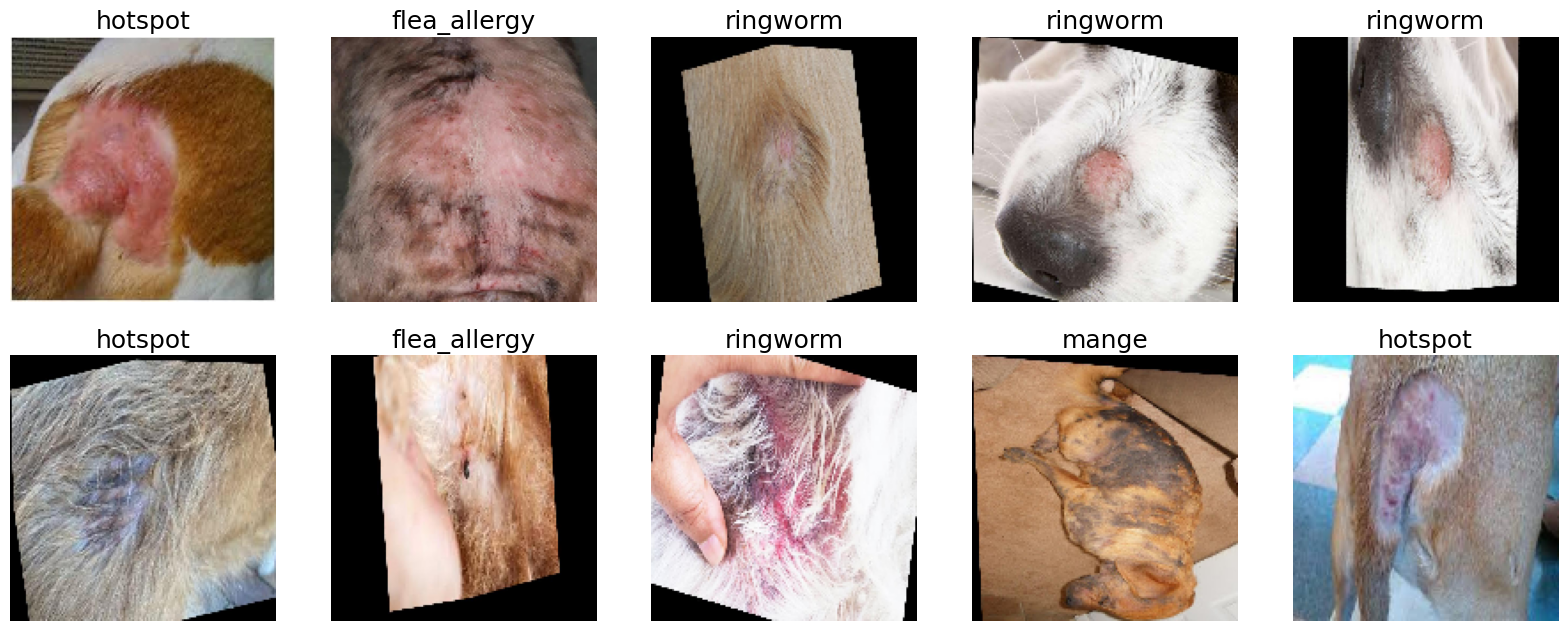

In [19]:
show_image_samples(train_generator)

###Modelling CNN Sederhana

In [20]:
def create_model():

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Dense(16, activation='relu'),
      #tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [21]:
model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 74, 74, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 87616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │       2,803,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,804,244 (10.70 MB)

 Trainable params: 2,804,244 (10.70 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Mendefenisikan fungsi Callback
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.00001,
    verbose=1,
)
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Checkpoint
checkpoint_path = 'model_checkpoints/SkinDisease.weights.h5'  # Updated file extension
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,  # Ensures only weights are saved
    verbose=1
)


In [28]:
history = model.fit(train_generator,
            epochs=50,
            validation_data=validation_generator,
            verbose = 1,
            callbacks = [early_stopping, checkpoint])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3076 - loss: 1.6264
Epoch 1: val_loss improved from inf to 1.28096, saving model to model_checkpoints/SkinDisease.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.3087 - loss: 1.6166 - val_accuracy: 0.3125 - val_loss: 1.2810
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4178 - loss: 1.2552
Epoch 2: val_loss improved from 1.28096 to 1.09089, saving model to model_checkpoints/SkinDisease.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4195 - loss: 1.2538 - val_accuracy: 0.5625 - val_loss: 1.0909
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6646 - loss: 0.9277
Epoch 3: val_loss improved from 1.09089 to 0.73224, saving model to model_checkpoints/SkinDisease.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6646 - loss: 0.9271 - val_accuracy: 0.8000 - val_loss: 0.7322
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8637 - loss: 0.59

###Plot dan Evaluasi

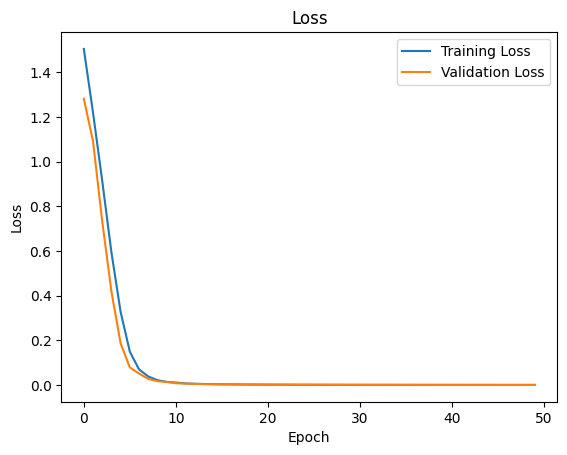

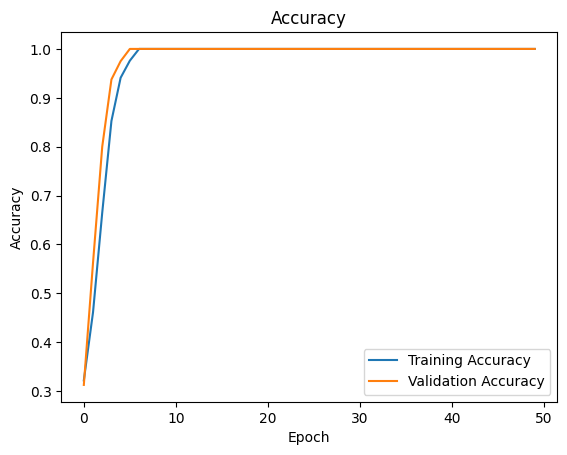

In [29]:
# Obtain training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Draw loss plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()
print()

# Draw accuracy plot
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [32]:
TEST_DIR = "/content/dogSkinDisease/test"
#TRAINING_DIR = "/content/dogSkinDisease/train"

test_datagen = ImageDataGenerator(rescale = 1.0 / 255. )

# pass in the appropriate arguments to the flow_from_directory method
test_set_2 = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

Found 80 images belonging to 4 classes.


In [33]:
Y_pred_2 = model.predict(test_set_2)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [34]:
print(classification_report(test_set_2.classes, y_pred_2))

              precision    recall  f1-score   support

           0       0.35      0.35      0.35        20
           1       0.05      0.05      0.05        20
           2       0.25      0.25      0.25        20
           3       0.35      0.35      0.35        20

    accuracy                           0.25        80
   macro avg       0.25      0.25      0.25        80
weighted avg       0.25      0.25      0.25        80



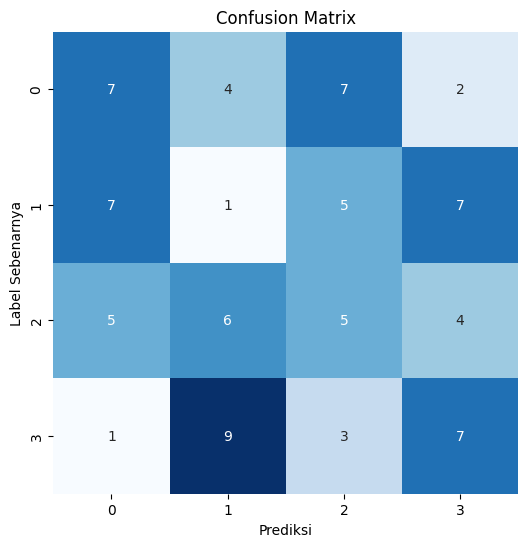

In [35]:
# Misalkan test_set_2.classes adalah label yang sebenarnya dan y_pred_2 adalah label prediksi
y_true = test_set_2.classes  # Label yang sebenarnya
y_pred = y_pred_2  # Label prediksi

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix dalam bentuk heatmap
class_names = ['0', '1', '2', '3']  # Nama kelas (sesuaikan dengan kelas Anda)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

###Save Model h5

In [36]:
#Save model to h5 format

model.save("SkinDisease.h5")

###Predict New Images


In [37]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1.0/225.)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['flea_allergy', 'hotspot', 'mange', 'ringworm']
  df['Animal'] = prod
  df = df[['Animal', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'flea_allergy'
  elif predict_label == 1:
      predict_product = 'hotspot'
  elif predict_label == 2:
      predict_product = 'mange'
  else:
      predict_product = 'ringworm'

  return predict_product, df

Saving ringworm.jpg to ringworm.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step




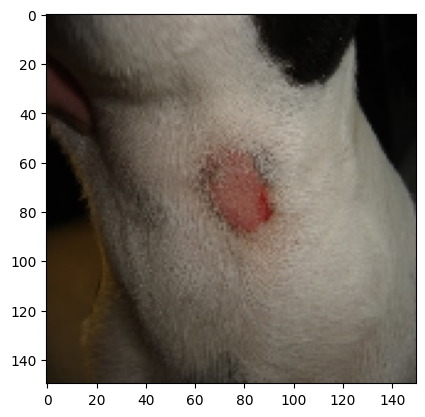


The image is detected as ringworm


         Animal  Probability
0  flea_allergy     0.000013
1       hotspot     0.000031
2         mange     0.000004
3      ringworm     0.999952




In [40]:
from keras.preprocessing import image
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.preprocessing.image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')